# Project: Suspect Detection in Surveillance Video

**Final Project - AASD4016: Full Stack Data Science**

**Professor:**

**Student ID:** 101373529 

**Student Name:** Gonçalves, Ednaldo

## Objectives

## Import Libraries

In [2]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D,  MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, Activation, Input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random
import cv2
import os
import time
import csv

## 1 - Load and Preparing the Dataset

Data used: [Kaggle](https://www.kaggle.com/code/mehmetokuyar/criminal-dedection/input)

### 1.1 - Crop faces and generate CSV file from Images Dataset

In [23]:
# function to generate CSV file from dataset images
def list_image_files(root_dir):
    image_files = []

    # Recursively traverse directories
    for root, dirs, files in os.walk(root_dir):
        # For each file, check if it is an image and add it to the list
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_files.append((os.path.join(root, file), os.path.basename(root)))

    return image_files

In [3]:
def extract_faces_csv(image_files_list):
    
    # loading the haar case algorithm file into alg variable
    #alg = "haarcascade_frontalface.xml"
    #alg = "haarcascade_frontalcatface_extended.xml"
    alg = "haarcascade_frontalface_default.xml"
    
    # passing the algorithm to OpenCV
    haar_cascade = cv2.CascadeClassifier(alg)
    
    # CSV file path to save the data
    csv_file_path = 'data/stored_faces.csv'
    
    # Write data to the CSV file
    with open(csv_file_path, 'w', newline='') as csvfile:
        # open file to write
        writer = csv.writer(csvfile)
        
        # Write the CSV header
        writer.writerow(['img_path', 'img_name', 'full_name'])
        
        j = 0
        # Write the data of each file in the list
        for file_path, full_name in image_files_list:
            
            # ************************
            # EXTRACT FACES FROM IMAGE
            # ************************
            # loading the image path into file_name variable
            file_name = file_path
            
            # reading the image
            img = cv2.imread(file_name, 0)
            
            # creating a black and white version of the image
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            # detecting the faces
            faces = haar_cascade.detectMultiScale(
                img, scaleFactor=1.05, minNeighbors=2, minSize=(224, 224))
            
            i = 0
            # for each face detected
            for x, y, w, h in faces:
                
                # crop the image to select only the face
                cropped_image = img[y : y + h, x : x + w]
                
                # loading the target image path into target_file_name variable
                target_file_name = 'data/stored_faces/' + str(j) + '_' + str(i) + '.jpg'
                
                # crop face from image and save
                cv2.imwrite(
                    target_file_name,
                    cropped_image,
                )
                
                # ************************
                # SAVE CSV FILE
                # ************************
                # write the data of each file in the list
                img_filename = target_file_name.split("/")[-1]
                writer.writerow([target_file_name, img_filename, full_name])
                
                i = i + 1
                
            j = j + 1
            
    print("Extract faces and CSV file saved successfully!")

In [4]:
# Root directory to be traversed
root_directory = 'data/celebrity_faces_dataset'

# Get list of image files with directory name
image_files = list_image_files(root_directory)

# Crop faces and generate CSV file from Image Dataset
extract_faces_csv(image_files)

Extract faces and CSV file saved successfully!


### 1.2 - Dataset Images

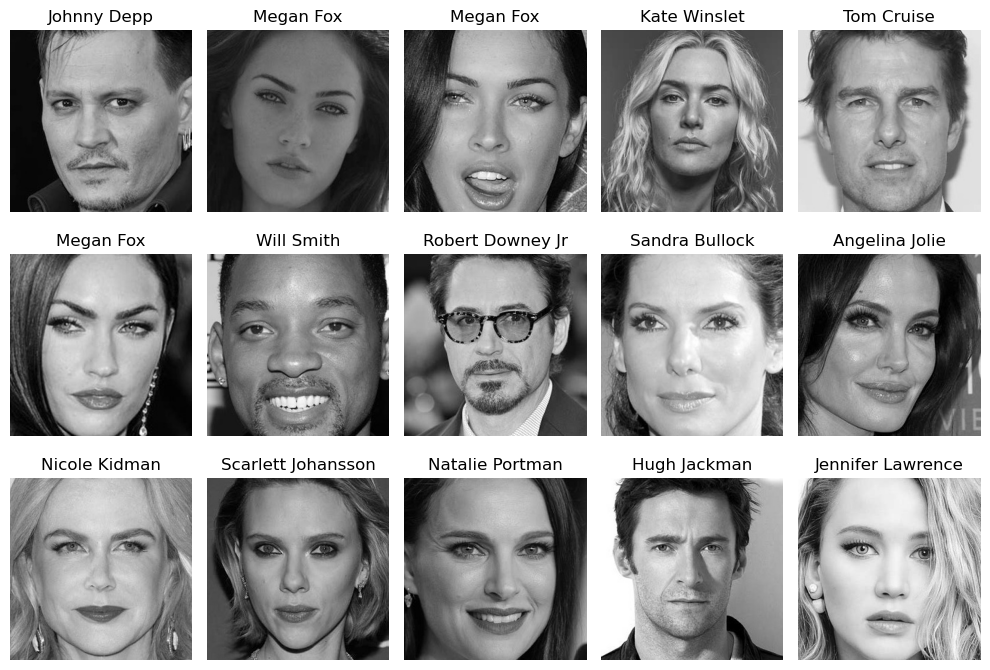

In [4]:
# Read the CSV file
df = pd.read_csv('data/stored_faces.csv')

# Select random entries from the DataFrame
random_rows = df.sample(n=15)

# Plot the selected images
plt.figure(figsize=(10, 7))
for i, (_, row) in enumerate(random_rows.iterrows(), start=1):
    
    plt.subplot(3, 5, i)
    img = mpimg.imread(row['img_path'])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(row['full_name'])

plt.tight_layout()
plt.show()


### 1.3 - Dataset Names

In [5]:
# read the first 5 records of dataset
df.head(5)

,img_path,img_name,full_name
0,data/stored_faces/0_0.jpg,0_0.jpg,Robert Downey Jr
1,data/stored_faces/1_0.jpg,1_0.jpg,Robert Downey Jr
2,data/stored_faces/2_0.jpg,2_0.jpg,Robert Downey Jr
3,data/stored_faces/4_0.jpg,4_0.jpg,Robert Downey Jr
4,data/stored_faces/5_0.jpg,5_0.jpg,Robert Downey Jr


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   1278 non-null   object
 1   img_name   1278 non-null   object
 2   full_name  1278 non-null   object
dtypes: object(3)
memory usage: 30.1+ KB


### 1.4 - Preparing the Dataset

#### Generator for data augmentation

The idea of manipulating images with rotation and resizing arises from a basic premise of activities involving Deep Learning and Machine Learning, which is the representativeness of the data sample used to train a model. The larger the sample and the more representative the data used in the training stage, the better the model will perform when classifying new data. Thus, by rotating the images and resizing them, we increase our sample space, generating greater data variability, causing our model to learn characteristics presented in another "form".

In [4]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [7]:
# construct the image generator for data augmentation
# Uses techniques to generate new images from existing ones (applying random transformations: 
# distortion, rotation, zoom, etc.) for datasets with few images. 
# Obviously, the more images to train, the better the model.

def transform(input_image, input_label, input_batch_size, how_many):
    
    # Create ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
        
    # Load image
    img = load_img(input_image)  # PIL image
    
    # Convert image to numpy array
    x = img_to_array(img)  # shape: (height, width, channels)
    
    # Resize the image to 224x224
    x = cv2.resize(x, (224, 224))   # Resize image to a fixed size
    
    # Reshape image to batch format
    x = np.expand_dims(x, axis=0)  # shape: (1, height, width, channels)
    
    # Generate augmented images
    augmented_images = []
    augmented_labels = []
    for batch in datagen.flow(x, batch_size=input_batch_size):
        augmented_images.append(array_to_img(batch[0]))  # Convert augmented image array to PIL image
        augmented_labels.append(input_label)
        if len(augmented_images) >= how_many:  # Generate number augmented images
            break
        
    return augmented_images, augmented_labels


In [8]:
# Function to load images and labels from the dataset
def load_dataset_augmentation(df, BS, how_many):
    # Images are captured and feature and input values are determined for future training.
    # Initialize lists to store resized images and corresponding full names
    data_images = []
    labels = []

    # Loop through the DataFrame
    for _, row in df.iterrows():
        
        # generate augmentation images
        new_data_images, new_labels = transform(row['img_path'], row['full_name'], BS, how_many)
        for n_img, n_label in zip(new_data_images, new_labels):
            data_images.append(n_img)
            labels.append(n_label)
            
    return np.array(data_images), np.array(labels)

In [10]:
# Function to load images and labels from the dataset
def load_dataset(df):
    
    # Images are captured and feature and input values are determined for future training.
    # Initialize lists to store resized images and corresponding full names
    data_images = []
    labels = []
    
    # Loop through the DataFrame
    for _, row in df.iterrows():
        
        image = cv2.imread(row['img_path'])
        image1 = cv2.resize(image,(224,224))
        image1 = img_to_array(image1)
        data_images.append(image1)
        labels.append(row['full_name'])
            
    return data_images, labels

In [7]:
# Load dataset and generate augmentation images
#batch_size = 32
#how_many_times = 5      # how many times to increase the dataset
#images, labels = load_dataset_augmentation(df, batch_size, how_many_times)

In [11]:
# Load dataset
batch_size = 32
images, labels = load_dataset(df)

In [12]:
print('Total images count {}'.format(len(images)))
print('Total labels count {}'.format(len(labels)))

Total images count 1278
Total labels count 1278


In [12]:
# Preprocess the images (normalize pixel values)
#images = images / 255.0

In [13]:
# Preprocess the images (normalize pixel values)
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

In [14]:
# Encode labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [11]:
# binarize the labels
#label_encoder = LabelBinarizer()
#labels_encoded = label_encoder.fit_transform(labels)

In [15]:
len(label_encoder.classes_)

17

In [16]:
# plot shape data
print('Train Images Shape:', images.shape)

Train Images Shape: (1278, 224, 224, 3)


#### Split data into training and validation sets

In [48]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

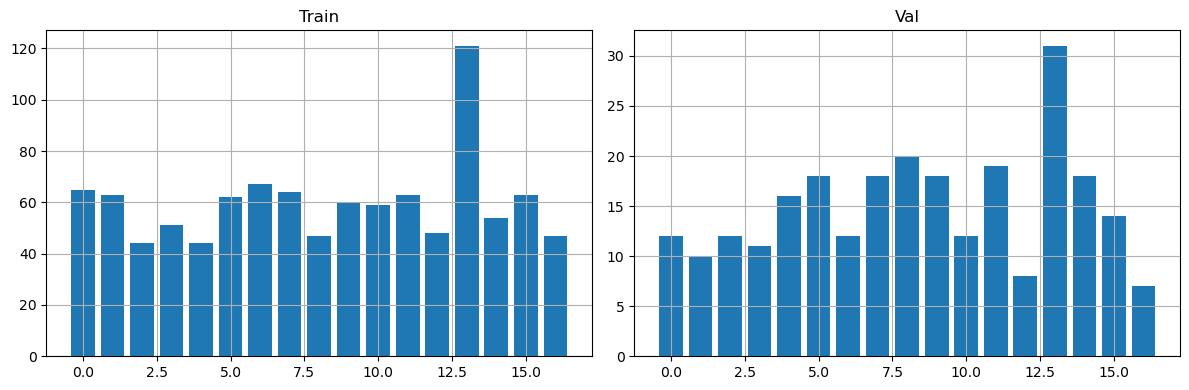

In [49]:

# Plotting histograms
plt.figure(figsize=(12, 4))

unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title("Train")

unique_valid, counts_valid = np.unique(y_val, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique_valid, counts_valid)
plt.grid()
plt.title("Val")

plt.tight_layout()
plt.show()

## 2 - Building the model

The trained network (structure and weights) is recorded, so that it can be used again later.

In [17]:
EPOCHS = 50
INIT_LR =1e-3
BS = 32

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(len(label_encoder.classes_), activation="softmax")(softmaxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=softmaxHead)

# Compile the model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model architecture summary

In [18]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

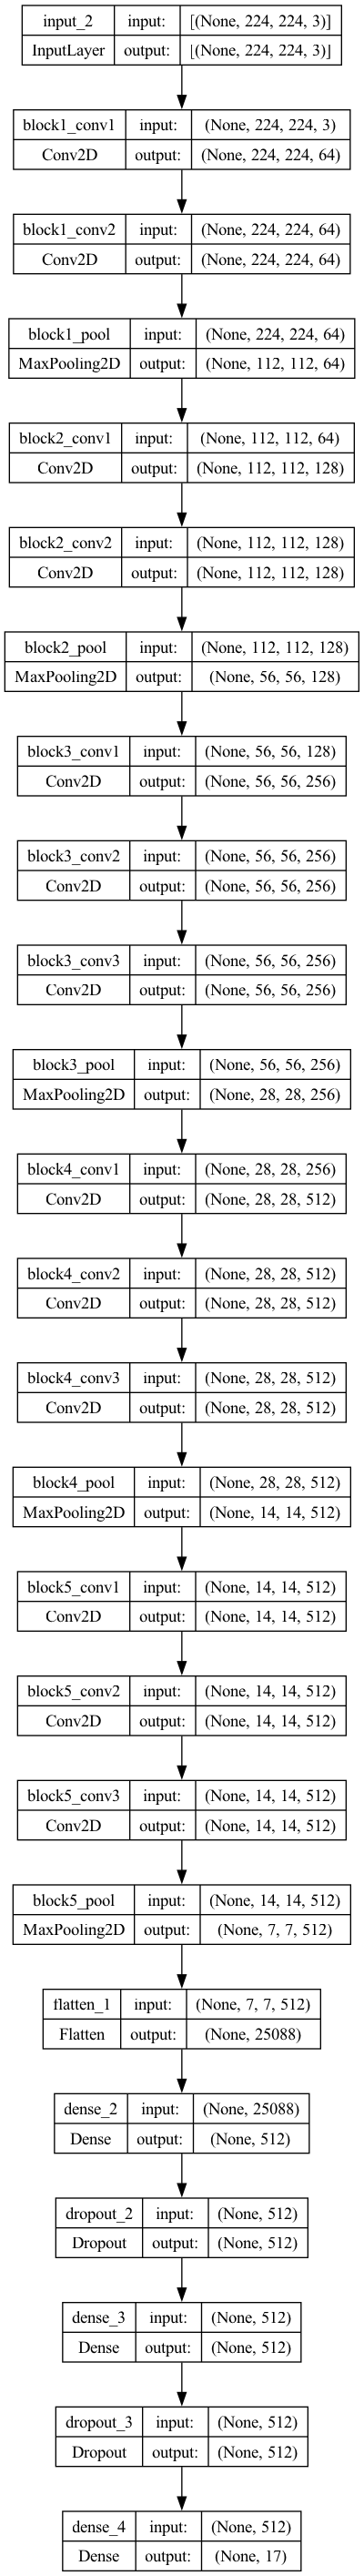

In [19]:
from tensorflow.keras.utils import plot_model

# View model diagram and save as image
plot_model(model, to_file='model.png', show_shapes=True)

## 3 - Training the Model

In [196]:
# Check GPU activation
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [54]:
EPOCHS = 50

# start time
start = time.time()

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Train the model
results = model.fit(
    X_train, y_train, batch_size,
    #x=aug.flow(X_train, y_train, batch_size=BS),
    epochs=EPOCHS, 
    validation_data=(X_val, y_val),
    #steps_per_epoch=len(X_train) // batch_size,
    verbose=1, 
    callbacks = [es]
    )

# Save the model
model.save("face_recognition_model.keras")

# print elapsed
print(f"Total time elapsed: {(time.time() - start)/60.} minutes")

Epoch 1/50
32/32 [==============================] - 91s 3s/step - loss: 3.6297 - accuracy: 0.1018 - val_loss: 2.5322 - val_accuracy: 0.1523
Epoch 2/50
32/32 [==============================] - 92s 3s/step - loss: 2.5374 - accuracy: 0.1928 - val_loss: 2.1981 - val_accuracy: 0.2891
Epoch 3/50
32/32 [==============================] - 91s 3s/step - loss: 2.2410 - accuracy: 0.2642 - val_loss: 2.0817 - val_accuracy: 0.3008
Epoch 4/50
32/32 [==============================] - 90s 3s/step - loss: 2.1048 - accuracy: 0.2838 - val_loss: 1.8534 - val_accuracy: 0.4453
Epoch 5/50
32/32 [==============================] - 93s 3s/step - loss: 1.8901 - accuracy: 0.3395 - val_loss: 1.7269 - val_accuracy: 0.4531
Epoch 6/50
32/32 [==============================] - 91s 3s/step - loss: 1.8745 - accuracy: 0.3405 - val_loss: 1.6621 - val_accuracy: 0.4102
Epoch 7/50
32/32 [==============================] - 91s 3s/step - loss: 1.7326 - accuracy: 0.3767 - val_loss: 1.6518 - val_accuracy: 0.5547
Epoch 8/50
32/32 [==

<Axes: >

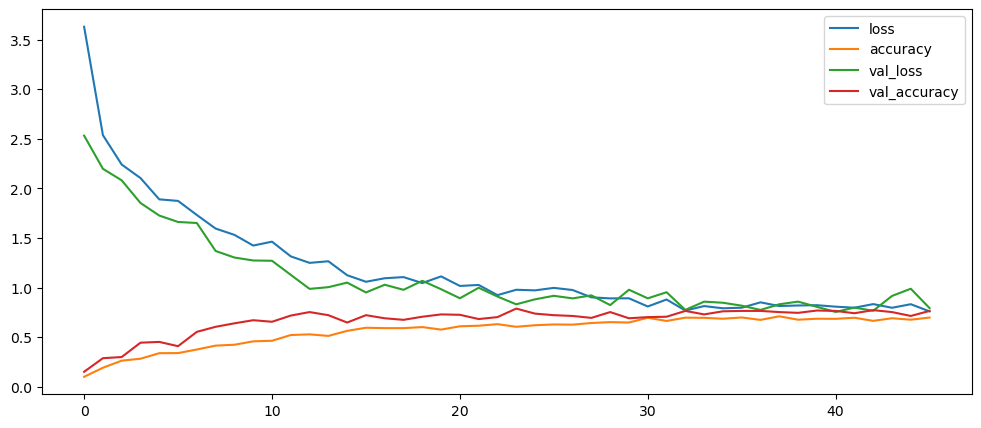

In [55]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,5))

## 4. Model Evaluation predictions on test data

In [56]:
score = model.evaluate(x=X_val,y=y_val,batch_size=32)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

8/8 [==============================] - 19s 2s/step - loss: 0.7938 - accuracy: 0.7656
Score Accuracy : 76.56%


In [57]:
label_encoder.classes_[:]

array(['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman',
       'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet',
       'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman',
       'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock',
       'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith'],
      dtype='<U18')

## 5 - Prediction

In [20]:
print("[INFO] loading object detector...")
model = load_model('face_recognition_model_v2.keras')

[INFO] loading object detector...


In [21]:
def predict(image):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = image.reshape(1,224,224,3)
    
    predictions = model.predict(image)[0]
    idx = np.argmax(predictions)
    print('Index: ' + str(idx))
    probability = predictions[idx] * 100
    print('Probability: ' + str(probability))
    label = label_encoder.classes_[idx]
    print('Person: ' + label)
    
    return label, probability

In [24]:
# Root directory to be predict
root_directory = 'data/test_detection/images'

# Get list of image files with directory name
image_files_predict = list_image_files(root_directory)
# read only first column of matrix
image_files_predict = [row[0] for row in image_files_predict]

In [35]:
import face_recognition

# Function to recognize the person's name from the detected face
def recognition_image_face(img_path):

    # Load the image
    img = cv2.imread(img_path) 

    # Convert the image to RGB (if using OpenCV which loads images in BGR format)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # creating a black and white version of the image
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Detect faces in the image
    face_locations = face_recognition.face_locations(img)

    # Iterate over detected faces
    for face_location in face_locations:
        top, right, bottom, left = face_location
        face_roi = img[top:bottom, left:right]

        # Recognize the face using your custom model
        person_name, probability = predict(face_roi)

        # Put the person's name on the image if probability >= 50%, else write "Unknown"
        if probability >= 50:
            #cv2.putText(img, person_name, (left, top-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(img, person_name, (left,top-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw rectangle around the face
            cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
        else:
            #cv2.putText(img, "Unknown", (left, top-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
            cv2.putText(img, "Unknown", (left,top-10), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255), 2)
            # Draw rectangle around the face
            cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
            
    return img

1/1 [==============================] - 0s 103ms/step
Index: 0
Probability: 65.9352958202362
Person: Angelina Jolie
1/1 [==============================] - 0s 102ms/step
Index: 14
Probability: 45.45242786407471
Person: Tom Cruise
1/1 [==============================] - 0s 108ms/step
Index: 14
Probability: 39.52917158603668
Person: Tom Cruise
1/1 [==============================] - 0s 104ms/step
Index: 11
Probability: 91.632479429245
Person: Robert Downey Jr
1/1 [==============================] - 0s 89ms/step
Index: 3
Probability: 24.14175719022751
Person: Hugh Jackman


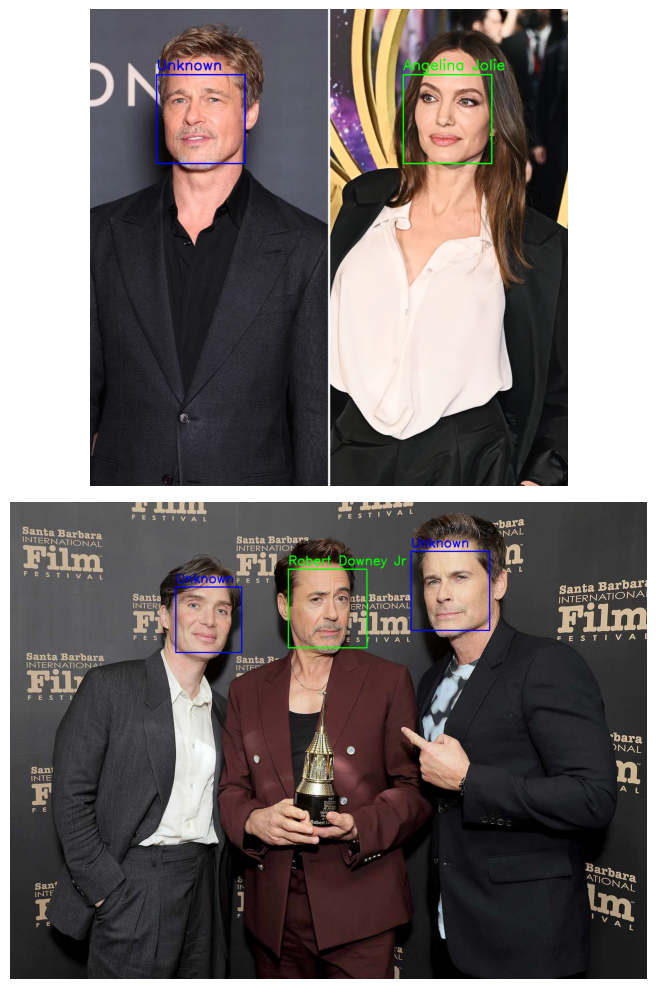

In [36]:
# Select random indices to choose images from the data list
random_indices = np.random.choice(len(image_files_predict), size=2, replace=False)

# Plot the selected images
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices, start=1):
    plt.subplot(2, 1, i)
    img = recognition_image_face(image_files_predict[index])
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()